In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options  


In [2]:
datetime.now()

datetime.datetime(2020, 2, 25, 9, 8, 37, 14688)

In [3]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [4]:
url = 'https://ncov.dxy.cn/ncovh5/view/pneumonia'
driver.get(url)

### Extract date

In [5]:
content = driver.page_source
soup =BeautifulSoup(content, 'lxml')


In [6]:
data = soup.findAll(text=re.compile("截至 .+"))
data

['try { window.getIndexRumorList = [{"id":174,"title":"中间层烧不着的口罩才是真的？","mainSummary":"解放日报辟谣：口罩是否可以被点燃，不是鉴别口罩真伪的标准","summary":"","body":"记者查阅到，口罩的主要材料有聚丙烯等。资料显示，聚丙烯是由丙烯聚合而制得的一种热塑性树脂，材料本身是可燃的。相关国家标准也仅对口罩的「易燃性」作了规定，如医用防护口罩国家标准《医用防护口罩技术要求GB 19083-2010》中规定「所用材料不应具有易燃性。续燃时间应不超过 5 秒」，没有「不可燃」这一要求。口罩是否可以被点燃，不是鉴别口罩真伪的标准。","sourceUrl":"","score":184,"rumorType":0},{"id":173,"title":"十年前就有人预测疫情？","mainSummary":"上海图书馆查证：没有找到传闻里提到的这本书，同名文章也没有相关内容","summary":"","body":"网传「陈国生写的一本叫《实证化中医基础理论及运用》的书在十年前预言了这次肺炎疫情」。上海图书馆进行了查证，没有检索到这本书。\\n在万方数据库里，可以查得陈国生所写《实证化中医基础理论依据及应用》这篇文章，发表在《2011 年全国天灾预测研讨学术会议论文集》中，题名和网传有一字之差，但能够对上年份和会议名称。但并未发现涉及任何与疫情预测相关的内容。","sourceUrl":"","score":183,"rumorType":0},{"id":172,"title":"美 1.4 万流感死者或部分死于新冠？","mainSummary":"美国疾控中心独家回应：目前无证据支持","summary":"","body":"针对日本朝日电视台此前惊人猜测「美国 1.4 万名因流感致死的人中部分可能死于新冠肺炎」，美国疾控中心（CDC）22 日回应环球时报-环球网记者表示，到目前为止，CDC 没有证据支持日本朝日电视台的相关猜测。\\nCDC 同时确认，截至 22 日晚，美国一共有 35 例新冠肺炎确诊病例。","sourceUrl":"","score":182,"rumorType":2},{"id":171,"title":"体温枪伤眼，造成永久伤害？","ma

In [7]:
for s in data:
    m = re.search("截至 (202\d-\d+-\d+ \d+:\d+)", s)
    if m is not None:
        data_date_time = m.group(1)
data_date_time

'2020-02-25 09:04'

### Extract data (summary)

In [8]:
data = soup.findAll(text=re.compile('\"summary.+\"confirmedCount\":\d'))

data


['try { window.getStatisticsService = {"id":1,"createTime":1579537899000,"modifyTime":1582621457000,"infectSource":"该字段已替换为说明2","passWay":"该字段已替换为说明3","imgUrl":"https://img1.dxycdn.com/2020/0201/450/3394153392393266839-135.png","dailyPic":"https://img1.dxycdn.com/2020/0211/763/3395998884005602079-135.png,https://img1.dxycdn.com/2020/0211/362/3395998896890788910-135.png,https://img1.dxycdn.com/2020/0211/365/3395998905480724211-135.png,https://img1.dxycdn.com/2020/0211/364/3395998916217859778-135.png,https://img1.dxycdn.com/2020/0211/922/3395998929103046444-135.png,https://img1.dxycdn.com/2020/0211/089/3395998939840182072-135.png","dailyPics":["https://img1.dxycdn.com/2020/0211/763/3395998884005602079-135.png","https://img1.dxycdn.com/2020/0211/362/3395998896890788910-135.png","https://img1.dxycdn.com/2020/0211/365/3395998905480724211-135.png","https://img1.dxycdn.com/2020/0211/364/3395998916217859778-135.png","https://img1.dxycdn.com/2020/0211/922/3395998929103046444-135.png","https://i

In [9]:
m = re.search('\"confirmedCount\":(\d+)', data[0])
summary_confirmed_count = int(m.group(1))


m = re.search('\"curedCount\":(\d+)', data[0])
summary_cured_count = int(m.group(1))

m = re.search('\"deadCount\":(\d+)', data[0])
summary_dead_count = int(m.group(1))


In [10]:
# make a dataframe
df = pd.DataFrame({
    'datetime': data_date_time,
    'confirmed': summary_confirmed_count,
    'cured': summary_cured_count,
    'dead': summary_dead_count
}, index=[0])
df

,datetime,confirmed,cured,dead
0,2020-02-25 09:04,77782,27545,2666


### Save to file

In [11]:
from pathlib import Path
csv_file = 'data/china-summary-cases.csv'

if Path(csv_file).exists():
    # read out the old data - then merge with new data and remove duplicates based on datetime
    old_df = pd.read_csv(csv_file)
    df = df.append(old_df)
df.drop_duplicates(subset=['datetime'], inplace=True)

In [12]:
df.sort_values(by=['datetime'], inplace=True)

df.to_csv(csv_file, index=False)


### Plot graph

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

png_file = 'images/china-summary-cases.png'
# convert to pd.datetime
df['datetime_idx'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M")

df.set_index('datetime_idx', inplace=True)
df.drop(['datetime'], axis=1, inplace=True)


In [14]:
df

,confirmed,cured,dead
datetime_idx,,,
2020-02-02 10:22:00,14483,379,304
2020-02-02 10:28:00,14483,380,304
2020-02-02 11:19:00,14489,385,304
2020-02-02 11:54:00,14489,397,304
2020-02-02 15:01:00,14490,430,304
...,...,...,...
2020-02-25 04:07:00,77779,27414,2666
2020-02-25 04:48:00,77779,27441,2666
2020-02-25 06:43:00,77781,27463,2666


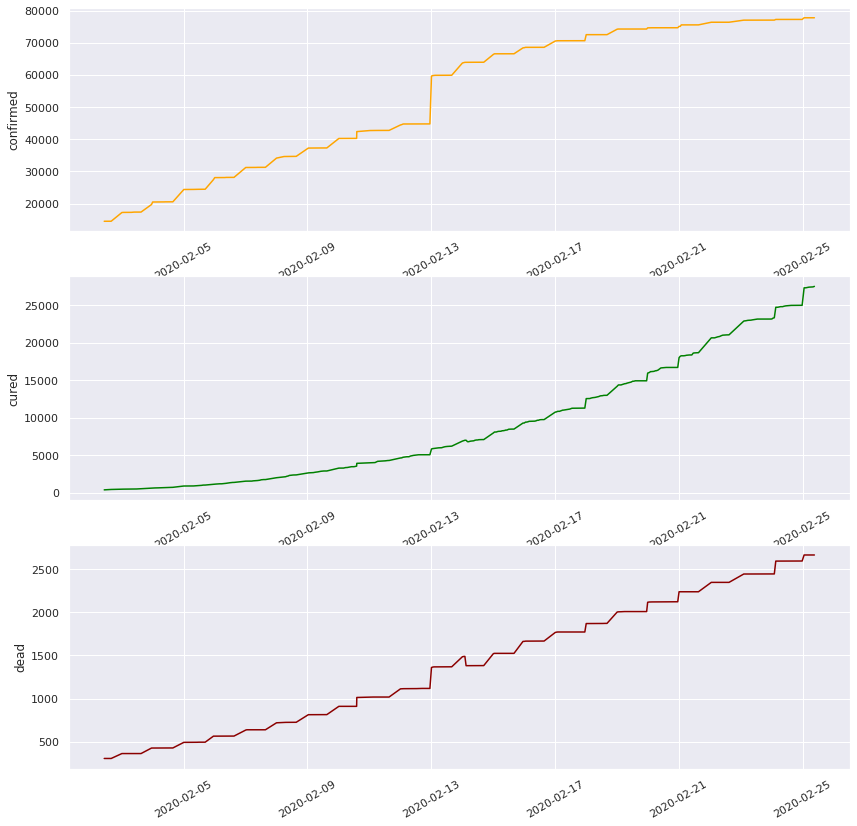

In [15]:
if df.shape[0]>1:
    # line chart when having at least a few points
    sns.set(rc={'figure.figsize':(14,14)})

    fig, axs = plt.subplots(nrows=3)

    sns.lineplot(x=df.index, y = 'confirmed', data=df, ax= axs[0], estimator=None, color='orange')
    sns.lineplot(x=df.index, y = 'cured', data=df, ax= axs[1], estimator=None, color='green')
    sns.lineplot(x=df.index, y = 'dead', data=df, ax= axs[2], estimator=None, color='darkred')

    for ax in axs:
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelrotation=30)
else:

    ax = df.plot(kind='bar', stacked=True, figsize=(9,6))
    fig = ax.get_figure()
    ax.set_xlabel('')
    for label in ax.get_xticklabels():
        label.set_rotation(0) 


In [16]:
fig.savefig(png_file)